In [27]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import geopandas as gpd
from prettytable import PrettyTable
from datetime import datetime, date

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime, timedelta
from ipywidgets import interact
import itertools
from tabulate import tabulate

In [28]:
csv_files = glob.glob(os.path.join('data_IN','data_*.csv'))
#print csv_files which is a list of filenames
print(csv_files)
 
#intialize empty list that we will append dataframes to
list_data = []
 
 
#write a for loop that will go through each of the file name through globbing and the end result will be the list of dataframes
for filename in csv_files:
    data = pd.read_csv(filename)
    data = data.drop(['Sr.No'], axis=1)
    list_data.append(data)
 
#print list_data which is a list of dataframes
list_data
 
cdf = pd.concat(list_data,ignore_index=False, sort=True)
#cdf.head()
cdf.to_csv('combined.csv')

['data_IN/data_2020-04-06.csv', 'data_IN/data_2020-04-08.csv', 'data_IN/data_2020-04-07.csv', 'data_IN/data_2020-04-10.csv', 'data_IN/data_2020-04-09.csv']


# Plotting the data for a state

In [29]:
# Columns to use
colsList = ['Confirmed', 'Recovered', 'Deceased']

# Get dataframe for States
def getStateCovidFr(StateName):
    StateCovidFr = cdf[cdf['States/UT'] == StateName]
    StateCovidFr.sort_values(by=['Date'], inplace=True, ascending=True)
    return StateCovidFr

def convertDateToReadableFormat(dateList):
    dtObjectList = []
    for dateInt in dateList:
        dateStr = str(dateInt)
        print(dateStr)
        x = datetime(int(dateStr[:4]), int(dateStr[5:7]), int(dateStr[8:]))
        dtObjectList.append(x)
    dateTimeList = [dtObject.strftime('%y-%m-%d') for dtObject in dtObjectList]
    return dateTimeList, dtObjectList

# Function for plotting  state data
def plotStateData(StateName, logScale=False, tablesToUse='all'):
    '''
    tablestoUse is either 'all' or a list of table names from colsList
    '''
    StateCovidFr = getStateCovidFr(StateName)
    dateList = StateCovidFr['Date'].tolist()
    readableDateList, _ = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    #readableDateList.reverse()
    
    StateCovidDataDict = {}
    for col in colsList:
        dataList = StateCovidFr[col].tolist()
        #dataList.reverse()
        StateCovidDataDict[col] = dataList
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    if tablesToUse == 'all':
        for col in colsList:
            ax.plot(readableDateList, StateCovidDataDict[col], marker='o', label=col);
    else:
        for tableToUse in tablesToUse:
            ax.plot(readableDateList, StateCovidDataDict[tableToUse], marker='o', label=tableToUse);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')

2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10


/home/soumik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Confirmed,Date,Deceased,Recovered,States/UT,Unnamed: 0,Unnamed: 0.1
18,490,2020-04-06,24,42,Maharashtra,18,18.0
18,748,2020-04-07,45,56,Maharashtra,18,18.0
18,868,2020-04-08,48,56,Maharashtra,18,18.0
18,1018,2020-04-09,64,79,Maharashtra,18,NaN
18,1135,2020-04-10,72,117,Maharashtra,18,NaN


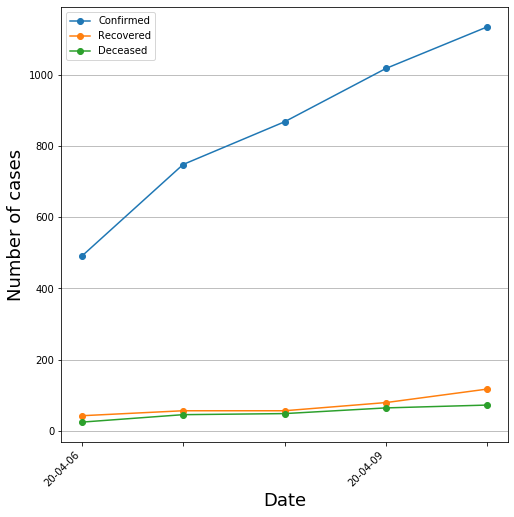

In [30]:
plotStateData('Maharashtra', tablesToUse=['Confirmed', 'Recovered', 'Deceased'])
getStateCovidFr('Maharashtra')

# Plot data with predictions for next n days

In [31]:
def getPredictionsForFuture_State(StateName,
                                    nDays=1,
                                    invertible=False, # Whether model is invertible or not
                                    plot=True,
                                    logScale=False,
                                    grid=None,
                                    printResults=True,
                                    tablesToUse='all',
                                    returnResults=False):
    '''
    tablesToUse is either 'all' for all tables, otherwise use a list containing one or more of 'confirmed', 'recovered' or 'deaths'
    '''
    
    # Extract model parameters
    p, d, q = (1, 2, 2)
    
    StateCovidFr = getStateCovidFr(StateName)
    dateList = StateCovidFr['Date'].tolist()
    readableDateList, dtObjectList = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    readableDateList.reverse()
    dtObjectList.reverse()
    
    StateCovidDataDict = {}
    for col in colsList:
        dataList = StateCovidFr[col].tolist()
        dataList.reverse()
        StateCovidDataDict[col] = dataList
    
    plotStartedFlag = False
    if tablesToUse == 'all':
        keysList = StateCovidFr.keys()
    else:
        keysList = tablesToUse
    allData = {}
    predData = {}
    for key in keysList:
        data = list(StateCovidDataDict[key])
#         if len(data) == 0:
#             allDataDict = dict(zip(datetimeForPlotList, [0]*len(datetimeForPlotList)))
#             allData[key] = allDataDict
#             continue
            
        predictionsList = []

        for i in range(nDays):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])
            
        # Required for printing as well as plotting
        dateTimeOjectForPlotList = dtObjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%y-%m-%d') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%y-%m-%d') for dateTimeObject in futureDateTimeObjectList]
        
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl'))
            
                
        if plot:
            # Start a plot if not already started
            if plotStartedFlag == False:
                fig = plt.figure(figsize=(8,8))
                ax = fig.add_subplot(111)
                plotStartedFlag = True
            if logScale:
                for i in range(len(data)):
                    if data[i] == 0:
                        data[i] = np.nan
            ax.plot(datetimeForPlotList, data, marker='o', label=key);
            # Circle predictions
            ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        allDataDict = dict(zip(datetimeForPlotList, data))
        allData[key] = allDataDict

        predDict = dict(zip(futureDateTimeList, predictionsList))
        predData[key] = predDict
    if plot:
        if logScale:
            plt.yscale('log')
        plt.xticks(rotation=45, ha="right");
        
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        ax.legend(loc='upper left', prop={'size': 18});
        plt.title('Data for {}\n(Including predictions for next {} days)'.format(StateName, nDays), fontsize=24);
        plt.xlabel('Date', fontsize=18);
        if logScale:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
        if grid != None:
            plt.grid(axis=grid)
        
    if returnResults:
        return allData, predData

In [32]:
allData, predData = getPredictionsForFuture_State('Maharashtra',
                                                    nDays=1,
                                                    invertible=False,
                                                    plot=True,
                                                    logScale=False,
                                                    grid='y',
                                                    printResults=True,                                                     
                                                    tablesToUse=['Confirmed'],                                                    
                                                    returnResults=True)

2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10


/home/soumik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


ValueError: maxlag should be < nobs